<a href="https://colab.research.google.com/github/BmMoghaddam/Land-Use-and-Land-Cover-Classification-with-Deep-Learning-and-Multispectral-Data---SPACERAISE-AIKO/blob/main/SPACERAISE_AIKO_HandsonSession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 Land Use and Land Cover Classification with Deep Learning and Multispectral Data

Welcome! In this notebook, we will develop a deep learning pipeline to classify satellite images based on Land Use and Land Cover (LULC) types using the EuroSAT dataset and multispectral Sentinel-2 imagery.

---

## 🎯 Objectives

- Train and evaluate a deep convolutional neural network (CNN) to classify satellite images into 10 LULC categories.
- Explore the use of multispectral data from Sentinel-2 for EO applications.
- Gain hands-on experience with PyTorch, TorchMetrics, and MobileNetV2 for onboard-like inference scenarios.

---

## 📦 What we will do

1. **Download and explore** the EuroSAT dataset (multispectral version).  
2. **Preprocess** and structure the data into training/validation/test splits.  
3. **Build and train** a MobileNetV2 model optimized for lightweight inference.  
4. **Evaluate** model performance using standard metrics (accuracy, precision, recall, F1).  
5. **Visualize** predictions and interpret the confusion matrix.

---

## ⚙️ Tools & Technologies

- **Python** for scripting and data processing  
- **Google Colab** for cloud-based development and access to GPUs  
- **PyTorch** as the deep learning framework  
- **Rasterio** for handling geospatial imagery  
- **TorchMetrics** for evaluation

---

Let's get started 🚀

## Problem Specification
The objective of this task is to develop a classification model capable of assigning a Land Use Land Cover (LULC) class to satellite imagery. The model takes as input a single Earth Observation (EO) image and outputs a corresponding LULC label, representing the dominant land use or cover type (e.g., urban, forest, agriculture, water). The goal is to enable automated interpretation of EO data to support environmental monitoring, urban planning, and resource management.

To summarize:
- Input: EO image
- AI model: Classification Convoluational Neural Network (CNN)
- Output: LULC Label


In [1]:
# Install some libraries
!pip install rasterio
!pip install torchmetrics
# Import libraries
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.models import resnet18, MobileNetV2
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

##Data Retrieval

## 🌍 EuroSAT Dataset: Land Use and Land Cover Classification Benchmark

**EuroSAT** is a popular dataset for Land Use and Land Cover (LULC) classification. It is based on **Sentinel-2** satellite imagery and includes:

* **13 spectral bands**
* **10 LULC classes**
* A total of **27,000 labeled and geo-referenced images**

### Land Use / Land Cover Classes:

* Annual Crop
* Forest
* Herbaceous Vegetation
* Highway
* Industrial
* Pasture
* Permanent Crop
* Residential
* River
* Sea Lake

---

## About Sentinel-2

Sentinel-2 is part of the **Copernicus Programme**, a European Union Earth observation initiative focused on environmental monitoring, land use, agriculture, forestry, disaster control, and climate change.

* Operated by the **European Space Agency (ESA)**
* Acquires optical imagery in visible and infrared wavelengths over land and coastal areas

---

### Sentinel-2 Spectral Bands Overview

| Band | Name                    | Wavelength (nm) | Resolution | Typical Use Case                         |
| ---- | ----------------------- | --------------- | ---------- | ---------------------------------------- |
| B01  | Coastal aerosol         | 443             | 60 m       | Coastal and aerosol studies              |
| B02  | Blue                    | 490             | 10 m       | True color, water body analysis          |
| B03  | Green                   | 560             | 10 m       | True color                               |
| B04  | Red                     | 665             | 10 m       | True color, vegetation index             |
| B05  | Red edge 1              | 705             | 20 m       | Chlorophyll, vegetation stress           |
| B06  | Red edge 2              | 740             | 20 m       | Vegetation analysis                      |
| B07  | Red edge 3              | 783             | 20 m       | Vegetation analysis                      |
| B08  | Near Infrared (NIR)     | 842             | 10 m       | Vegetation health (e.g., NDVI)           |
| B8A  | Narrow NIR (Red Edge 4) | 865             | 20 m       | Vegetation discrimination                |
| B09  | Water vapor             | 945             | 60 m       | Atmospheric correction                   |
| B10  | SWIR – Cirrus           | 1375            | 60 m       | Cloud detection (cirrus)                 |
| B11  | SWIR 1                  | 1610            | 20 m       | Soil moisture, burn areas                |
| B12  | SWIR 2                  | 2190            | 20 m       | Snow/ice/clouds, geological applications |

---

## References

* EuroSAT dataset: [https://zenodo.org/records/7711810](https://zenodo.org/records/7711810#.ZAm3k-zMKEA)
* Sentinel-2 mission details: [https://sentiwiki.copernicus.eu/web/s2-mission](https://sentiwiki.copernicus.eu/web/s2-mission)


In [2]:
# bash commands to download and unzip data

#(ALL BANDS)
#!wget -O EuroSat.zip https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1
#!unzip /content/EuroSat.zip

#(RGB)
!wget -O EuroSat.zip https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
!unzip /content/EuroSat.zip


Streaming output truncated to the last 5000 lines.
  inflating: EuroSAT_RGB/Residential/Residential_489.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1573.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_270.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_516.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2683.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_502.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2697.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_264.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2867.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2873.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_258.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2126.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1349.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2640.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2898.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2654.j

##Explorative Data Analysis

### 🧹 **What is Data Preparation?**

**Data preparation** is the process of converting raw, unstructured data into a clean and organized format that can be effectively used to train AI models.

---

### 🔑 **Key Steps in Data Preparation**

* **Data Collection**: Gather data from sensors, files, APIs, or databases.
* **Data Cleaning**: Fix errors, remove duplicates, and handle missing or inconsistent values.
* **Labeling**: Assign labels or classes to data samples (for supervised learning).
* **Normalization / Scaling**: Standardize feature ranges to improve model performance.
* **Data Splitting**: Divide data into training, validation, and test sets.
* **Exploratory Data Analysis (EDA)**: Analyze distributions, correlations, and data patterns.
* **Data Augmentation (Optional)**: Create variations of existing data to enrich the dataset and improve generalization.

### **Dataset Structure**

```
# EuroSAT_RGB
  |- Annual Crop
    !-*.jpg
  |- Forest
    !-*.jpg
  |- Herbaceous Vegetations
    !-*.jpg
  |- Highway
    !-*.jpg
  |- Indistrual
    !-*.jpg
  |- Pasture
    !-*.jpg
  |- Permanent Crop
    !-*.jpg
  |- Residential
    !-*.jpg
  |- River
    !-*.jpg
  !- Sea Lale
    !-*.jpg
```

In [ ]:
# Dataset path
#DATASET_PATH = "/content/EuroSAT_MS"
DATASET_PATH = "/content/EuroSAT_RGB"

# Get the number of images per category
for category in os.listdir(DATASET_PATH):
  cat_images = len(os.listdir(os.path.join(DATASET_PATH, category)))
  print(f"{category} has {cat_images} images")


Highway has 2500 images
Forest has 3000 images
AnnualCrop has 3000 images
Residential has 3000 images
River has 2500 images
PermanentCrop has 2500 images
Industrial has 2500 images
Pasture has 2000 images
SeaLake has 3000 images
HerbaceousVegetation has 3000 images


Image width: 64
Image height: 64
Number of bands: 3
Data type: uint8
Image Statistics:
Min: [37 63 72]
Max: [255 255 251]
Mean: [116.27099609 119.47119141 113.93798828]
Standard Deviation: [51.82245361 31.16242652 27.85034403]


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


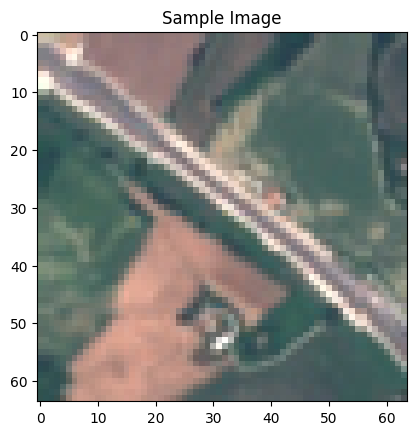

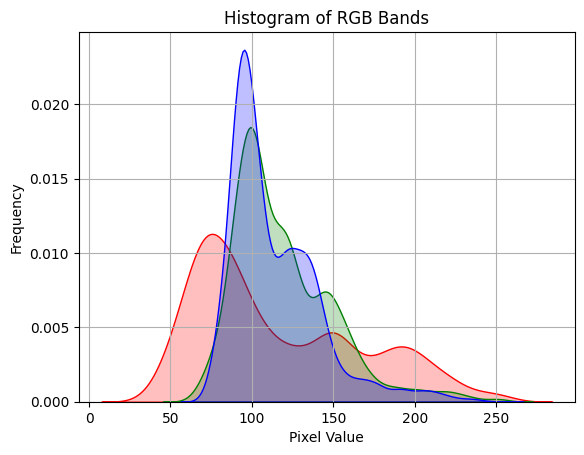

In [ ]:
# Read a sample image using rasterio
#sample_image_path = "/content/EuroSAT_MS/Highway/Highway_1.tif"'
sample_image_path = "/content/EuroSAT_RGB/Highway/Highway_1.jpg"

with rasterio.open(sample_image_path) as src:
  print(f"Image width: {src.width}")
  print(f"Image height: {src.height}")
  print(f"Number of bands: {src.count}")
  print(f"Data type: {src.dtypes[0]}")

  image_data = src.read()

# print image statistics
print(f"Image Statistics:")
print(f"Min: {np.min(image_data, axis=(1,2))}")
print(f"Max: {np.max(image_data, axis=(1,2))}")
print(f"Mean: {np.mean(image_data, axis=(1,2))}")
print(f"Standard Deviation: {np.std(image_data, axis=(1,2))}")

# Get the RGB bands
#rgb_image = image_data[[3,2,1], :, :]
rgb_image = image_data[:, :, :]


# Plot the image
plt.imshow(np.transpose(rgb_image/np.max(rgb_image), (1, 2, 0)))
plt.title("Sample Image")
plt.show()

# Plot the pixel-frequency histogram
plt.figure()
colors = ['red', 'green', 'blue']

#bands_to_plot = [3, 2, 1]
bands_to_plot = [0,1,2]

for i, color in zip(bands_to_plot, colors):
  band_data = image_data[i, :, :].flatten()
  sns.kdeplot(band_data, fill=True, color=color)
plt.grid()
plt.title(f"Histogram of RGB Bands")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


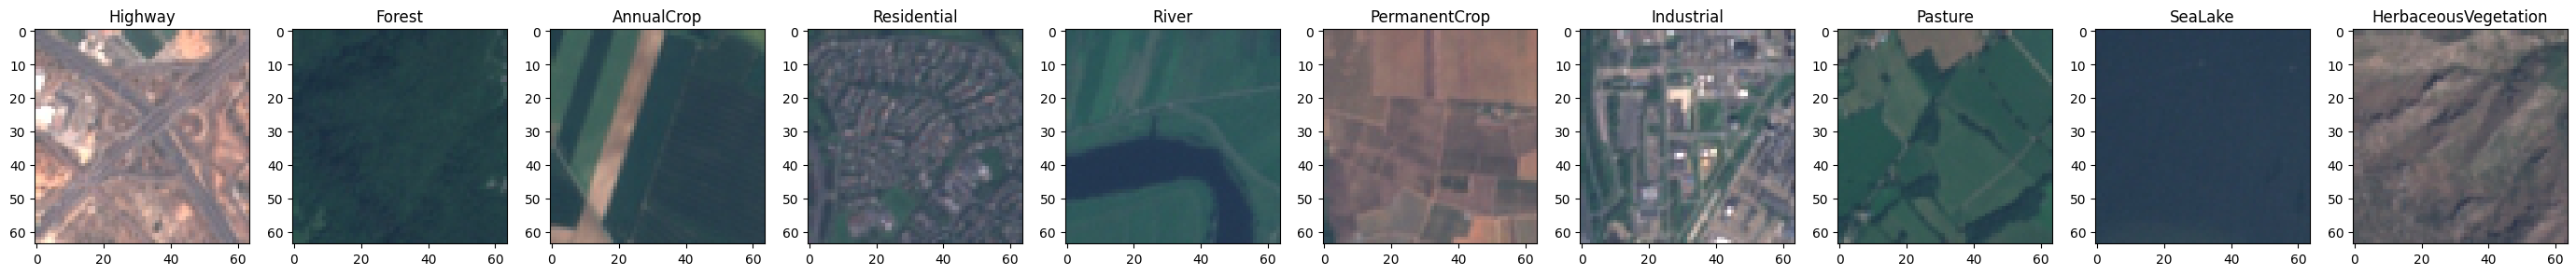

In [ ]:
# Get the number of images per category
plt.figure(figsize=[35,10])

for num, category in enumerate(os.listdir(DATASET_PATH)):

  sample_name = os.listdir(f"{DATASET_PATH}/{category}")[0]

  with rasterio.open(f"{DATASET_PATH}/{category}/{sample_name}") as src:
    image_data = src.read()

  # Get the RGB bands
  #rgb_image = image_data[[3,2,1], :, :]
  rgb_image = image_data[[0,1,2], :, :]


  # Plot the image
  plt.subplot(1,10,num+1)
  #plt.imshow(np.transpose(rgb_image/5000, (1, 2, 0)))
  plt.imshow(np.transpose(rgb_image, (1, 2, 0)))
  plt.title(category)
plt.show()

## Data Loader

### 📦 **What is a DataLoader?**

A **DataLoader** in PyTorch is a tool that automates the process of loading data in batches for training or evaluation. It handles:

* **Batching**: Groups data samples into mini-batches.
* **Shuffling**: Randomizes data order for each epoch (to avoid learning order bias).
* **Parallel Loading**: Loads data using multiple workers for faster training.

---

### 🧪 **Why We Divide into Train / Validation / Test Sets**

* **Train Set**:
  Used to teach the model. It updates the model's weights through learning.

* **Validation Set**:
  Used to tune hyperparameters and monitor performance **during training**. Helps detect **overfitting**.

* **Test Set**:
  Used **after training** to evaluate the final model performance on **unseen data**. Gives an unbiased estimate of how well the model will perform in real-world scenarios.


In [ ]:
class EuroSATDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        with rasterio.open(img_path) as src:
            #image = src.read().astype(np.float32)[[3,2,1],:,:] # RGB Channels with MS Scenario
            image = src.read().astype(np.float32)[:,:,:] # RGB Channels wi RGB Scenario


        if self.transform:
            image = self.transform(image)

        return torch.tensor(image), torch.tensor(label, dtype=torch.long)

# Get all image paths and labels
all_image_paths = []
all_labels = []
classes = sorted(os.listdir(DATASET_PATH))
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

for class_name in classes:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for image_name in os.listdir(class_dir):
        all_image_paths.append(os.path.join(class_dir, image_name))
        all_labels.append(class_to_idx[class_name])


# Split data into training, validation, and test sets 20-20-60
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.6, random_state=42, stratify=all_labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.50, random_state=42, stratify=train_labels
)

## Split data into training, validation, and test sets 60-20-20
#train_paths, test_paths, train_labels, test_labels = train_test_split(
#    all_image_paths, all_labels, test_size=0.20, random_state=42, stratify=all_labels
#)
#
#train_paths, val_paths, train_labels, val_labels = train_test_split(
#    train_paths, train_labels, test_size=0.25, random_state=42, stratify=train_labels
#)


# Create training, validation, and test datasets
train_dataset = EuroSATDataset(train_paths, train_labels)
val_dataset = EuroSATDataset(val_paths, val_labels)
test_dataset = EuroSATDataset(test_paths, test_labels)

# print the size of the splits
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of val_dataset: {len(val_dataset)}")
print(f"Length of test_dataset: {len(test_dataset)}\n")

# Create DataLoaders for training, validation, and test
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle validation data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data

# Iterate through the dataloaders (example)
print("Training data batch shapes:")
for images, labels in train_dataloader:
     print(images.shape, labels.shape)
     break

print("\nValidation data batch shapes:")
for images, labels in val_dataloader:
     print(images.shape, labels.shape)
     break

print("\nTest data batch shapes:")
for images, labels in test_dataloader:
     print(images.shape, labels.shape)
     break

Length of train_dataset: 5400
Length of val_dataset: 5400
Length of test_dataset: 16200

Training data batch shapes:


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


torch.Size([128, 3, 64, 64]) torch.Size([128])

Validation data batch shapes:
torch.Size([128, 3, 64, 64]) torch.Size([128])

Test data batch shapes:
torch.Size([128, 3, 64, 64]) torch.Size([128])


## Architecture definition

### 🧠 **How a CNN for Classification is Structured**

A **Convolutional Neural Network (CNN)** for classification typically follows this architecture:

1. **Input Layer**

   * Receives the image (e.g., 3×224×224 for RGB).

2. **Convolutional Layers**

   * Apply filters (kernels) to extract spatial features like edges, textures, and patterns.

3. **Activation Functions (ReLU)**

   * Introduce non-linearity to model complex relationships.

4. **Pooling Layers (MaxPooling)**

   * Reduce spatial dimensions to lower computation and improve feature robustness.

5. **Fully Connected Layers**

   * Flatten the feature maps and connect to dense layers for final decision making.

6. **Output Layer (Softmax)**

   * Produces class probabilities.

---

### 📱 **What is MobileNetV2?**

**MobileNetV2** is a lightweight and efficient CNN architecture designed for mobile and embedded devices. It achieves high accuracy with fewer computations.

### ✅ **Advantages of MobileNetV2**

* Very **fast and lightweight** – ideal for mobile or embedded systems.
* **Good accuracy vs. speed trade-off**.
* Can be used with **limited resources** (low power, small memory).

---

### ❌ **Disadvantages of MobileNetV2**

* **Lower accuracy** than heavier models (like ResNet-50 or EfficientNet) on large-scale tasks.
* May struggle with **very complex patterns** due to compact size.
* Requires **careful tuning** when used for transfer learning or fine-tuning.


In [ ]:
# Load  MobileNetV2
mobilenet_model = MobileNetV2()
mobilenet_model.features[0][0] = nn.Conv2d(3, mobilenet_model.features[0][0].out_channels, kernel_size=mobilenet_model.features[0][0].kernel_size, stride=mobilenet_model.features[0][0].stride, padding=mobilenet_model.features[0][0].padding, bias=mobilenet_model.features[0][0].bias)
num_ftrs_mobilenet = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_ftrs_mobilenet, 10) # Assuming 10 classes for EuroSAT

In [ ]:
# Model Dimensions (Number of Parameters)
total_params = sum(p.numel() for p in mobilenet_model.parameters() if p.requires_grad)
print(f"Total trainable parameters (M): {total_params/10**6}")

# Model Inference Time (using a sample batch from the test set)
mobilenet_model.eval() # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model.to(device)

# Get a sample batch from the test dataloader
sample_images, _ = next(iter(test_dataloader))
sample_images = sample_images.to(device)

# Measure inference time
start_time = time.time()
with torch.no_grad():
    _ = mobilenet_model(sample_images)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time for one batch: {inference_time:.4f} seconds")

# 3. Layers of Architecture Visualization
print("\nModel Architecture:")
print(mobilenet_model)

Total trainable parameters (M): 2.236682
Inference time for one batch: 0.5582 seconds

Model Architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
     

## Training Loop

### 🔁 **Training Loop Overview (for Classification)**

A **training loop** is the core process where a model learns from data. It usually includes both **training** and **validation** steps.

---

### ⚙️ **Main Steps in the Training Loop**

1. **Forward Pass**

   * The model takes input data and makes predictions.

2. **Loss Calculation**

   * Compares predictions to true labels using a loss function (e.g., CrossEntropyLoss).

3. **Backward Pass (Backpropagation)**

   * Computes gradients of the loss with respect to model weights.

4. **Optimizer Step**

   * Updates the model weights using the gradients.

5. **Validation Step**

   * After each epoch, test the model on unseen data to check generalization.

---

### 🔍 **Training vs. Validation**

* **Training**: Model learns by updating weights to minimize loss on training data.
* **Validation**: Evaluates performance on a separate dataset to detect overfitting and ensure generalization.

---

### 📊 **Evaluation Metrics**

* **Accuracy**:
  Proportion of correct predictions.

  $$
  \text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Samples}}
  $$

* **Precision**:
  Of all predicted positive samples, how many were truly positive?

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
  $$

* **Recall**:
  Of all actual positive samples, how many were correctly predicted?

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
  $$

* **F1 Score**:
  Harmonic mean of Precision and Recall. Good for imbalanced classes.

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision + Recall}}
  $$

---

### ❌ **What is CrossEntropy Loss?**

**CrossEntropy Loss** is used in classification tasks to measure the difference between the predicted probability distribution and the true label.

* For a single sample:

  $$
  \text{Loss} = -\sum y_i \log(\hat{y}_i)
  $$

  where $y_i$ is the true label (as one-hot), and $\hat{y}_i$ is the predicted probability.

* It penalizes wrong predictions more strongly when the model is confident but incorrect.

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=0.001)

# number of epochs
num_epochs = 10  # You can adjust this
# Ensure model is on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model.to(device)

# Initialize torchmetrics metrics
num_classes = 10 # Assuming 10 classes for EuroSAT

# Initialize metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision = Precision(task="multiclass", average='macro', num_classes=num_classes).to(device)
recall = Recall(task="multiclass", average='macro', num_classes=num_classes).to(device)
f1 = F1Score(task="multiclass", average='macro', num_classes=num_classes).to(device)

# Training Loop
for epoch in range(num_epochs):
    # Training Phase
    mobilenet_model.train()  # Set the model to training mode
    running_loss = 0.0 # Loss

    # Reset metrics
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    print(f"Epoch {epoch+1}/{num_epochs} - Training")

    # Iterate over bathces
    for images, labels in tqdm(train_dataloader):  # Use train_dataloader
        # Ensure data is on GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Perform inference
        outputs = mobilenet_model(images)
        # Compute loss
        loss = criterion(outputs, labels)

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)

        # Get the predictions
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        accuracy.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        f1.update(preds, labels)

    # Get metrics and loss
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = accuracy.compute()
    epoch_precision = precision.compute()
    epoch_recall = recall.compute()
    epoch_f1 = f1.compute()

    # print metrics
    print(f"Train Loss: {epoch_loss:.4f}, " + \
          f"Train Accuracy: {epoch_accuracy:.4f}, " + \
          f"Train Precision: {epoch_precision:.4f}, " + \
          f"Train Recall: {epoch_recall:.4f}, " + \
          f"Train F1-score: {epoch_f1:.4f}")

    # Validation Phase
    mobilenet_model.eval()  # Set the model to evaluation mode
    running_loss_val = 0.0
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    # Validation step
    print(f"Epoch {epoch+1}/{num_epochs} - Validation")
    with torch.no_grad():  # Disable gradient calculation during validation
        for images_val, labels_val in tqdm(val_dataloader):  # Use val_dataloader
            # Ensure data is on GPU
            images_val = images_val.to(device)
            labels_val = labels_val.to(device)

            # Inference
            outputs_val = mobilenet_model(images_val)
            # Compute loss
            loss_val = criterion(outputs_val, labels_val)

            running_loss_val += loss_val.item() * images_val.size(0)

            # Get predictions
            preds_val = torch.argmax(outputs_val, dim=1)
            # Update metrics
            accuracy.update(preds_val, labels_val)
            precision.update(preds_val, labels_val)
            recall.update(preds_val, labels_val)
            f1.update(preds_val, labels_val)

    # Compute metrics
    epoch_loss_val = running_loss_val / len(val_dataloader.dataset)
    epoch_accuracy_val = accuracy.compute()
    epoch_precision_val = precision.compute()
    epoch_recall_val = recall.compute()
    epoch_f1_val = f1.compute()

    # print metrics
    print(f"Validation Loss: {epoch_loss_val:.4f}, " + \
          f"Validation Accuracy: {epoch_accuracy_val:.4f}, " + \
          f"Validation Precision: {epoch_precision_val:.4f}, " + \
          f"Validation Recall: {epoch_recall_val:.4f}, " + \
          f"Validation F1-score: {epoch_f1_val:.4f}")

print("Training finished.")

Epoch 1/10 - Training


100%|██████████| 43/43 [00:12<00:00,  3.35it/s]


Train Loss: 1.5439, Train Accuracy: 0.4333, Train Precision: 0.4003, Train Recall: 0.4180, Train F1-score: 0.4048
Epoch 1/10 - Validation


100%|██████████| 43/43 [00:10<00:00,  4.17it/s]


Validation Loss: 3.4736, Validation Accuracy: 0.0741, Validation Precision: 0.0074, Validation Recall: 0.1000, Validation F1-score: 0.0138
Epoch 2/10 - Training


100%|██████████| 43/43 [00:12<00:00,  3.56it/s]


Train Loss: 1.1116, Train Accuracy: 0.5952, Train Precision: 0.5674, Train Recall: 0.5813, Train F1-score: 0.5710
Epoch 2/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.62it/s]


Validation Loss: 1.1361, Validation Accuracy: 0.5889, Validation Precision: 0.5784, Validation Recall: 0.5757, Validation F1-score: 0.5619
Epoch 3/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.75it/s]


Train Loss: 0.9124, Train Accuracy: 0.6724, Train Precision: 0.6548, Train Recall: 0.6626, Train F1-score: 0.6573
Epoch 3/10 - Validation


100%|██████████| 43/43 [00:10<00:00,  4.25it/s]


Validation Loss: 1.0260, Validation Accuracy: 0.6285, Validation Precision: 0.6342, Validation Recall: 0.6269, Validation F1-score: 0.6047
Epoch 4/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.73it/s]


Train Loss: 0.8050, Train Accuracy: 0.7117, Train Precision: 0.6952, Train Recall: 0.7020, Train F1-score: 0.6976
Epoch 4/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.51it/s]


Validation Loss: 1.5697, Validation Accuracy: 0.5611, Validation Precision: 0.6104, Validation Recall: 0.5461, Validation F1-score: 0.5383
Epoch 5/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.75it/s]


Train Loss: 0.6925, Train Accuracy: 0.7419, Train Precision: 0.7297, Train Recall: 0.7332, Train F1-score: 0.7310
Epoch 5/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.63it/s]


Validation Loss: 1.0167, Validation Accuracy: 0.6567, Validation Precision: 0.6773, Validation Recall: 0.6561, Validation F1-score: 0.6461
Epoch 6/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.82it/s]


Train Loss: 0.6803, Train Accuracy: 0.7604, Train Precision: 0.7521, Train Recall: 0.7524, Train F1-score: 0.7515
Epoch 6/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.57it/s]


Validation Loss: 0.9846, Validation Accuracy: 0.6687, Validation Precision: 0.6806, Validation Recall: 0.6608, Validation F1-score: 0.6617
Epoch 7/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.69it/s]


Train Loss: 0.5779, Train Accuracy: 0.7924, Train Precision: 0.7844, Train Recall: 0.7870, Train F1-score: 0.7852
Epoch 7/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.51it/s]


Validation Loss: 1.0934, Validation Accuracy: 0.6754, Validation Precision: 0.6766, Validation Recall: 0.6660, Validation F1-score: 0.6579
Epoch 8/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.74it/s]


Train Loss: 0.5462, Train Accuracy: 0.8017, Train Precision: 0.7936, Train Recall: 0.7947, Train F1-score: 0.7939
Epoch 8/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.50it/s]


Validation Loss: 1.0408, Validation Accuracy: 0.7096, Validation Precision: 0.7156, Validation Recall: 0.6979, Validation F1-score: 0.6865
Epoch 9/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.79it/s]


Train Loss: 0.4846, Train Accuracy: 0.8339, Train Precision: 0.8292, Train Recall: 0.8301, Train F1-score: 0.8294
Epoch 9/10 - Validation


100%|██████████| 43/43 [00:08<00:00,  4.80it/s]


Validation Loss: 1.1256, Validation Accuracy: 0.6465, Validation Precision: 0.6438, Validation Recall: 0.6382, Validation F1-score: 0.6243
Epoch 10/10 - Training


100%|██████████| 43/43 [00:11<00:00,  3.75it/s]


Train Loss: 0.5351, Train Accuracy: 0.8120, Train Precision: 0.8042, Train Recall: 0.8055, Train F1-score: 0.8046
Epoch 10/10 - Validation


100%|██████████| 43/43 [00:09<00:00,  4.51it/s]

Validation Loss: 0.9365, Validation Accuracy: 0.7189, Validation Precision: 0.7120, Validation Recall: 0.7088, Validation F1-score: 0.7017
Training finished.


## Test

### 🧪 **Why Testing Is Done After Training and Validation**

Testing must be performed **after** training and validation to provide an **unbiased evaluation** of the model. Here's why:

Using the test set too early or too often can leak information and give an overly optimistic performance estimate.


### 📊 **What Is a Confusion Matrix?**

A **confusion matrix** is a table used to evaluate the performance of a classification model. It shows how often predictions match the true labels.

For a **binary classification** task, it looks like:

|                     | Predicted Positive  | Predicted Negative  |
| ------------------- | ------------------- | ------------------- |
| **Actual Positive** | True Positive (TP)  | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN)  |


100%|██████████| 127/127 [00:30<00:00,  4.23it/s]


Test Accuracy: 0.7036
Test Precision: 0.6954
Test Recall: 0.6925
Test F1-score: 0.6837


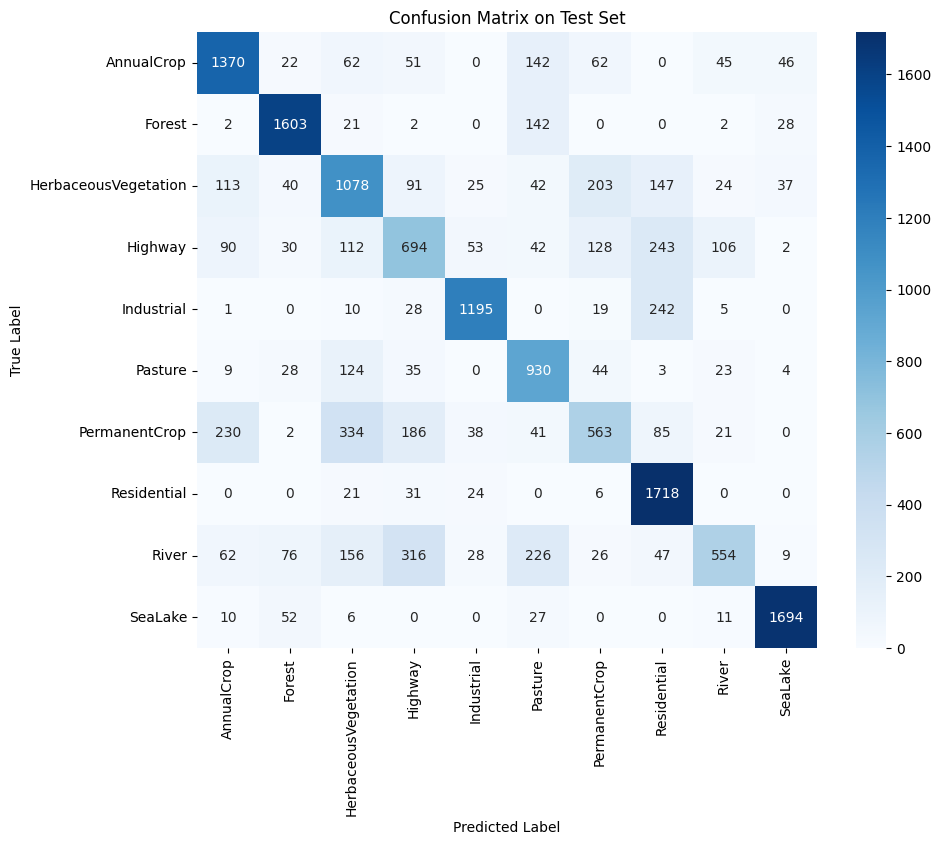

In [ ]:
# Evaluation on Test Set
mobilenet_model.eval()  # Set the model to evaluation mode

# Initialize for evaluation
accuracy.reset()
precision.reset()
recall.reset()
f1.reset()
all_preds = []
all_labels = []

# Loop over the test
with torch.no_grad():
    for images_test, labels_test in tqdm(test_dataloader):
        # Ensure have data on gpu
        images_test = images_test.to(device)
        labels_test = labels_test.to(device)

        # Inference
        outputs_test = mobilenet_model(images_test)
        # Get prediction
        preds_test = torch.argmax(outputs_test, dim=1)

        # Update metrics
        accuracy.update(preds_test, labels_test)
        precision.update(preds_test, labels_test)
        recall.update(preds_test, labels_test)
        f1.update(preds_test, labels_test)
        all_preds.extend(preds_test.cpu().numpy())
        all_labels.extend(labels_test.cpu().numpy())

# Compute metrics
test_accuracy = accuracy.compute()
test_precision = precision.compute()
test_recall = recall.compute()
test_f1 = f1.compute()

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()
